# Intro

We train mixture density network (https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) on 2D toy data. As target distribution we choose the individual modes to be gaussians.

# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%matplotlib inline

# Create toy dataset

One dimensional sine function with noise from two different gaussians with zero mean

In [13]:
N = 4000
N_val = 1000
max_tr = 20
min_val = 0
max_val = 20
sig1 = 0.1
sig2 = 0.3

# Training
X = np.random.uniform(0, max_tr, size=N)
Y = np.zeros((N,2))
Y[:, 0] = np.sin(X) + np.random.normal(loc=0, scale=0.3, size=N)
Y[:, 1] = np.cos(X) + np.random.normal(loc=0, scale=0.1, size=N)

# Validation
X_val = np.random.uniform(min_val, max_val, N_val)
Y_val = np.zeros((N_val,2))
Y_val[:, 0] = np.sin(X_val) + np.random.normal(loc=0, scale=0.3, size=N_val)
Y_val[:, 1] = np.cos(X_val) + np.random.normal(loc=0, scale=0.1, size=N_val)

Visualize data

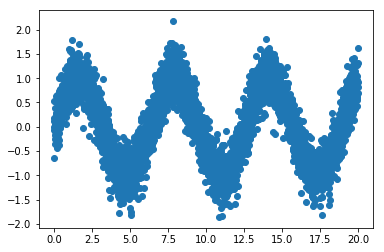

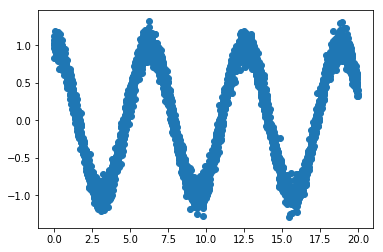

In [14]:
plt.figure()
plt.scatter(X, Y[:, 0])
plt.show()

plt.figure()
plt.scatter(X, Y[:, 1])
plt.show()

# Define model

Model can be used to train a normal dense network or a mixture density network

In [25]:
# Hyperparameters
lr = 0.001
lr_mdn = 0.001
batch_size = 128
epochs = 1000
patience = 20
modes = 1
dims = 2

In [35]:
def mdn_loss(y_true, y_pred):
    """
    Computes mdn loss
    
    args:
        y_true: labels plus dummy labels for std and weight 
        y_pred: prediction
        
    returns:
        loss
    """
    
    targets = y_true[:, :dims]
    means = y_pred[:, :modes*dims]
    std = tf.square(tf.exp(y_pred[:, modes*dims:2*modes*dims]))
    weights = y_pred[:, 2*modes*dims:2*modes*dims + modes]
    
    
    modes_prob = []
    for i in range(modes):
        log_prob = 0
        for j in range(dims):
            diff = tf.subtract(targets, means[:, i+j:(i+j+1)])
            log_prob += -1*tf.divide(tf.square(diff), 2*std[:, i+j:(i+j+1)]) - tf.sqrt(2*np.pi*std[:, i+j:(i+j+1)])
        log_prob += tf.log(weights[:, i:(i+1)])
        modes_prob.append(log_prob)
        
    prob = tf.concat(modes_prob, axis=1)
    
    loss = tf.reduce_logsumexp(prob, axis=1)
    loss = tf.reduce_mean(loss, axis=0)
    
    return (-1)*loss

In [36]:
def get_model(mdn=False, dims=2):
    
    inp = Input(shape=(1,))
    dense = Dense(100, activation='relu')(inp)
    dense = Dense(100, activation='relu')(dense)
    dense = Dense(100, activation='relu')(dense)
    
    if not mdn:
        out = Dense(dims)(dense)
    else:
        out_mean = Dense(dims*modes)(dense)
        
        out_std = Dense(dims*modes)(dense)
#         out_std = Lambda(lambda x: tf.abs(x))(out_std)
        
        
        out_weights = Dense(modes, activation='softmax')(dense)
#         out_weights = Lambda(lambda x: tf.abs(x)/(tf.reduce_sum(tf.abs(x))+1e-12))(out_weights)
        
        out = Concatenate(axis=1)([out_mean, out_std, out_weights])
    
    model = Model(inputs=[inp], outputs=[out])
    
    if not mdn:
        model.compile(Adam(lr=lr), loss='mse')
    else:
        model.compile(Adam(lr=lr_mdn), loss=mdn_loss)
    
    return model

Fit normal dense model to data

In [18]:
model = get_model(mdn=False)

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 202       
Total params: 20,602
Trainable params: 20,602
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(
    x = X,
    y = Y,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 0s 76us/step - loss: 0.6311 - val_loss: 0.5475
Epoch 2/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.5387 - val_loss: 0.5311
Epoch 3/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.5264 - val_loss: 0.5105
Epoch 4/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.5026 - val_loss: 0.4958
Epoch 5/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.4882 - val_loss: 0.4764
Epoch 6/1000
4000/4000 [==============================] - 0s 22us/step - loss: 0.4785 - val_loss: 0.4755
Epoch 7/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.4675 - val_loss: 0.4561
Epoch 8/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.4598 - val_loss: 0.4466
Epoch 9/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.4505 - val_loss: 0.4413
Epoch 1

Epoch 78/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.1574 - val_loss: 0.1622
Epoch 79/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.1543 - val_loss: 0.1510
Epoch 80/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.1449 - val_loss: 0.1436
Epoch 81/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.1428 - val_loss: 0.1367
Epoch 82/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.1398 - val_loss: 0.1394
Epoch 83/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.1357 - val_loss: 0.1314
Epoch 84/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.1315 - val_loss: 0.1377
Epoch 85/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.1286 - val_loss: 0.1229
Epoch 86/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.1229 - val_loss: 0.1178
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.0554 - val_loss: 0.0531
Epoch 156/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.0555 - val_loss: 0.0535
Epoch 157/1000
4000/4000 [==============================] - 0s 23us/step - loss: 0.0547 - val_loss: 0.0656
Epoch 158/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.0570 - val_loss: 0.0545
Epoch 159/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.0567 - val_loss: 0.0597
Epoch 160/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.0574 - val_loss: 0.0554
Epoch 161/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.0582 - val_loss: 0.0556
Epoch 162/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.0569 - val_loss: 0.0637
Epoch 163/1000
4000/4000 [==============================] - 0s 26us/step - loss: 0.0564 - val_loss: 0.0531
Epoch 164/1000
4000/4000 [===========

4000/4000 [==============================] - 0s 24us/step - loss: 0.0543 - val_loss: 0.0593
Epoch 232/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.0564 - val_loss: 0.0562
Epoch 233/1000
4000/4000 [==============================] - 0s 25us/step - loss: 0.0549 - val_loss: 0.0541
Epoch 234/1000
4000/4000 [==============================] - 0s 27us/step - loss: 0.0553 - val_loss: 0.0601
Epoch 235/1000
4000/4000 [==============================] - 0s 24us/step - loss: 0.0557 - val_loss: 0.0560


Visualize prediction

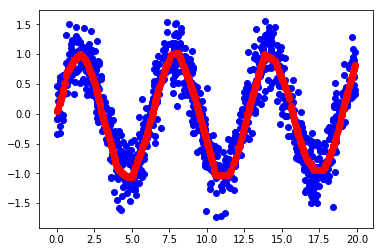

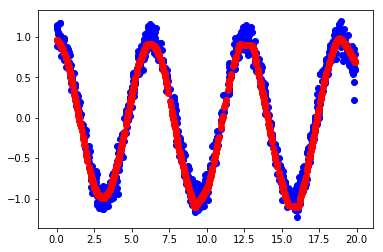

In [21]:
preds = model.predict(X_val)

plt.figure()
plt.scatter(X_val, Y_val[:, 0], color='b')
plt.scatter(X_val, preds[:, 0], color='r')
plt.show()

plt.figure()
plt.scatter(X_val, Y_val[:, 1], color='b')
plt.scatter(X_val, preds[:, 1], color='r')
plt.show()

Fit mixture density network to model

In [37]:
model_mdn = get_model(mdn=True)

In [38]:
model_mdn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 100)          200         input_5[0][0]                    
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 100)          10100       dense_21[0][0]                   
__________________________________________________________________________________________________
dense_23 (Dense)                (None, 100)          10100       dense_22[0][0]                   
__________________________________________________________________________________________________
dense_24 (

In [39]:
Y_mdn = np.concatenate([np.reshape(Y, (Y.shape[0], dims)), np.zeros((Y.shape[0], modes*3-dims))], axis=1)
Y_mdn_val = np.concatenate([np.reshape(Y_val, (Y_val.shape[0], dims)), np.zeros((Y_val.shape[0], modes*3-dims))], axis=1)

model_mdn.fit(
    x = X,
    y = Y_mdn,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val, Y_mdn_val],
    callbacks = [
        EarlyStopping(patience=patience)
    ]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/1000
4000/4000 [==============================] - 1s 162us/step - loss: 3.7556 - val_loss: 3.4030
Epoch 2/1000
4000/4000 [==============================] - 0s 39us/step - loss: 3.2705 - val_loss: 3.1803
Epoch 3/1000
4000/4000 [==============================] - 0s 41us/step - loss: 3.1705 - val_loss: 3.1164
Epoch 4/1000
4000/4000 [==============================] - 0s 42us/step - loss: 3.1182 - val_loss: 3.1993
Epoch 5/1000
4000/4000 [==============================] - 0s 39us/step - loss: 3.1355 - val_loss: 3.0666
Epoch 6/1000
4000/4000 [==============================] - 0s 39us/step - loss: 3.0653 - val_loss: 3.1052
Epoch 7/1000
4000/4000 [==============================] - 0s 40us/step - loss: 3.0678 - val_loss: 3.0555
Epoch 8/1000
4000/4000 [==============================] - 0s 37us/step - loss: 3.0471 - val_loss: 3.0446
Epoch 9/1000
4000/4000 [==============================] - 0s 44us/step - loss: 3.0372 - val_loss: 3.1115
Epoch 

Epoch 78/1000
4000/4000 [==============================] - 0s 45us/step - loss: 2.2355 - val_loss: 2.2428
Epoch 79/1000
4000/4000 [==============================] - 0s 42us/step - loss: 2.2202 - val_loss: 2.1528
Epoch 80/1000
4000/4000 [==============================] - 0s 41us/step - loss: 2.1925 - val_loss: 2.2386
Epoch 81/1000
4000/4000 [==============================] - 0s 37us/step - loss: 2.2172 - val_loss: 2.1369
Epoch 82/1000
4000/4000 [==============================] - 0s 43us/step - loss: 2.1981 - val_loss: 2.1417
Epoch 83/1000
4000/4000 [==============================] - 0s 45us/step - loss: 2.1775 - val_loss: 2.2449
Epoch 84/1000
4000/4000 [==============================] - 0s 47us/step - loss: 2.1932 - val_loss: 2.2078
Epoch 85/1000
4000/4000 [==============================] - 0s 43us/step - loss: 2.1784 - val_loss: 2.2735
Epoch 86/1000
4000/4000 [==============================] - 0s 46us/step - loss: 2.2136 - val_loss: 2.2419
Epoch 87/1000
4000/4000 [=====================

Epoch 155/1000
4000/4000 [==============================] - 0s 41us/step - loss: 2.0432 - val_loss: 1.9692
Epoch 156/1000
4000/4000 [==============================] - 0s 43us/step - loss: 2.0173 - val_loss: 1.9904
Epoch 157/1000
4000/4000 [==============================] - 0s 42us/step - loss: 2.0425 - val_loss: 1.9764
Epoch 158/1000
4000/4000 [==============================] - 0s 43us/step - loss: 2.0216 - val_loss: 2.0012
Epoch 159/1000
4000/4000 [==============================] - 0s 44us/step - loss: 2.0278 - val_loss: 1.9674
Epoch 160/1000
4000/4000 [==============================] - 0s 45us/step - loss: 2.0221 - val_loss: 1.9802
Epoch 161/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.9914 - val_loss: 1.9463
Epoch 162/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.9700 - val_loss: 1.9286
Epoch 163/1000
4000/4000 [==============================] - 0s 37us/step - loss: 1.9622 - val_loss: 2.0291
Epoch 164/1000
4000/4000 [===========

4000/4000 [==============================] - 0s 42us/step - loss: 1.6035 - val_loss: 1.6760
Epoch 232/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.6395 - val_loss: 1.6033
Epoch 233/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.6070 - val_loss: 1.5484
Epoch 234/1000
4000/4000 [==============================] - 0s 40us/step - loss: 1.5510 - val_loss: 1.5570
Epoch 235/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.5201 - val_loss: 1.5302
Epoch 236/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.5171 - val_loss: 1.5512
Epoch 237/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.5063 - val_loss: 1.4817
Epoch 238/1000
4000/4000 [==============================] - 0s 41us/step - loss: 1.5039 - val_loss: 1.5446
Epoch 239/1000
4000/4000 [==============================] - 0s 39us/step - loss: 1.4518 - val_loss: 1.4264
Epoch 240/1000
4000/4000 [==========================

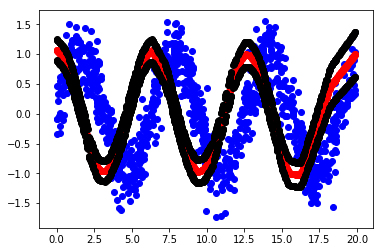

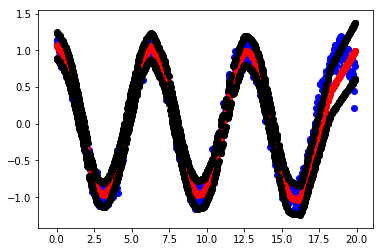

In [58]:
preds_mdn = model_mdn.predict(X_val)

preds_mdn_means = preds_mdn[:, :dims*modes]
preds_mdn_stds = preds_mdn[:, dims*modes:2*dims*modes]
preds_mdn_weights = preds_mdn[:, 2*dims*modes:2*dims*modes + modes]

preds_mdn_final = np.einsum('ijk,ik->ij',np.reshape(preds_mdn_means, (preds_mdn_means.shape[0], dims, modes)), 
                            preds_mdn_weights)
std_mdn_final = np.exp(np.einsum('ijk,ik->ij',np.reshape(preds_mdn_stds, (preds_mdn_stds.shape[0], dims, modes)), 
                            preds_mdn_weights))

for i in range(dims):
    plt.figure()
    plt.scatter(X_val, Y_val[:, i], color='b')
    plt.scatter(X_val, preds_mdn_final[:, i], color='r')
    plt.scatter(X_val, preds_mdn_final[:, i] + std_mdn_final[:, i], color='k')
    plt.scatter(X_val, preds_mdn_final[:, i] - std_mdn_final[:, i], color='k')
    plt.show()

In [59]:
print('Mean Sigmas:')
print(np.exp(preds_mdn_stds.mean(axis=0)))
print('Mean Weights:')
print(preds_mdn_weights.mean(axis=0))

Mean Sigmas:
[0.20412083 0.20312221]
Mean Weights:
[1.]


# Error comparison

Comparing the errors of normal model vs. mdn

In [62]:
error = np.mean(np.abs(preds - Y_val))
error_mdn = np.mean(np.abs(preds_mdn_final - Y_val))

print('Error normal: ' + str(error))
print('Error MDN: ' + str(error_mdn))

Error normal: 0.17356148584806383
Error MDN: 0.470692449708862


# Visualize uncertainty estimate

Variance depending on prediction error

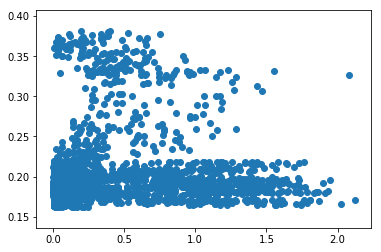

In [63]:
plt.figure()
plt.scatter(np.abs(preds_mdn_final - Y_val), std_mdn_final)
plt.show()

In [ ]:
np.sqrt(0.3**2 + 0.1**2)